In [95]:
import warnings
from sklearn import set_config 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, \
                    accuracy_score, f1_score, precision_score, recall_score
                    
import matplotlib.pyplot as plt
                    
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pandas.plotting import scatter_matrix


from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

# **Modelos de aprendizaje automático para estimar el uso de Bicing en una estación**

Este notebook contiene el código utilizado para el proyecto de APA ***Modelos de aprendizaje automático para estimar el uso
de Bicing en una estación*** realizado por **Nicolas Llorens** y **Fernando Guirao**.

## **Estudio preliminar del dataset**

In [123]:
data = pd.read_csv('dataset_generation/dataset.csv')

data.sample(5)

,hour,day,month,year,week_day,working_day,class_day,exits,temperature,a_temperature,humidity,precipitation,rain,wind_speed,demand_satisfied
8779,19,1,1,2022,5,0,3,1,8.0,6.4,98.6,0.0,0.0,7.4,1.0
10193,17,1,3,2022,1,1,1,10,12.5,10.0,71.8,0.0,0.0,13.1,0.0
17601,9,4,1,2023,2,1,3,1,7.7,4.9,92.7,0.0,0.0,13.0,1.0
17318,14,23,12,2022,4,1,1,9,20.3,19.2,57.0,0.0,0.0,11.2,1.0
6913,1,16,10,2021,5,0,3,1,15.4,16.2,96.5,0.0,0.0,5.2,1.0


### **Estadísticas descriptivas**

In [97]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hour,25536.0,NaN,NaN,NaN,11.5,6.922322,0.0,5.75,11.5,17.25,23.0
day,25536.0,NaN,NaN,NaN,15.712406,8.791936,1.0,8.0,16.0,23.0,31.0
month,25536.0,NaN,NaN,NaN,6.366541,3.3669,1.0,3.0,6.0,9.0,12.0
year,25536.0,NaN,NaN,NaN,2021.970865,0.81002,2021.0,2021.0,2022.0,2023.0,2023.0
week_day,25536.0,NaN,NaN,NaN,3.0,2.000039,0.0,1.0,3.0,5.0,6.0
working_day,25536.0,NaN,NaN,NaN,0.683271,0.46521,0.0,0.0,1.0,1.0,1.0
class_day,25536.0,NaN,NaN,NaN,2.18891,0.93142,1.0,1.0,3.0,3.0,3.0
exits,25536.0,NaN,NaN,NaN,2.257206,3.67823,0.0,0.0,1.0,3.0,42.0
temperature,25536.0,NaN,NaN,NaN,16.985589,7.0739,-1.6,11.6,17.0,22.5,36.8
a_temperature,25536.0,NaN,NaN,NaN,16.598367,8.969706,-6.1,9.5,16.3,24.1,40.3


### **Tratamiento de valores faltantes**

In [137]:
# Contamos los valores faltantes en la columna 'demand_satisfied'
missing_values_count = data['demand_satisfied'].isna().sum()

missing_values_count

# Eliminamos los registros donde 'demand_satisfied' es NaN
data = data.dropna(subset=['demand_satisfied'])

718

### **Distribución de las variables**

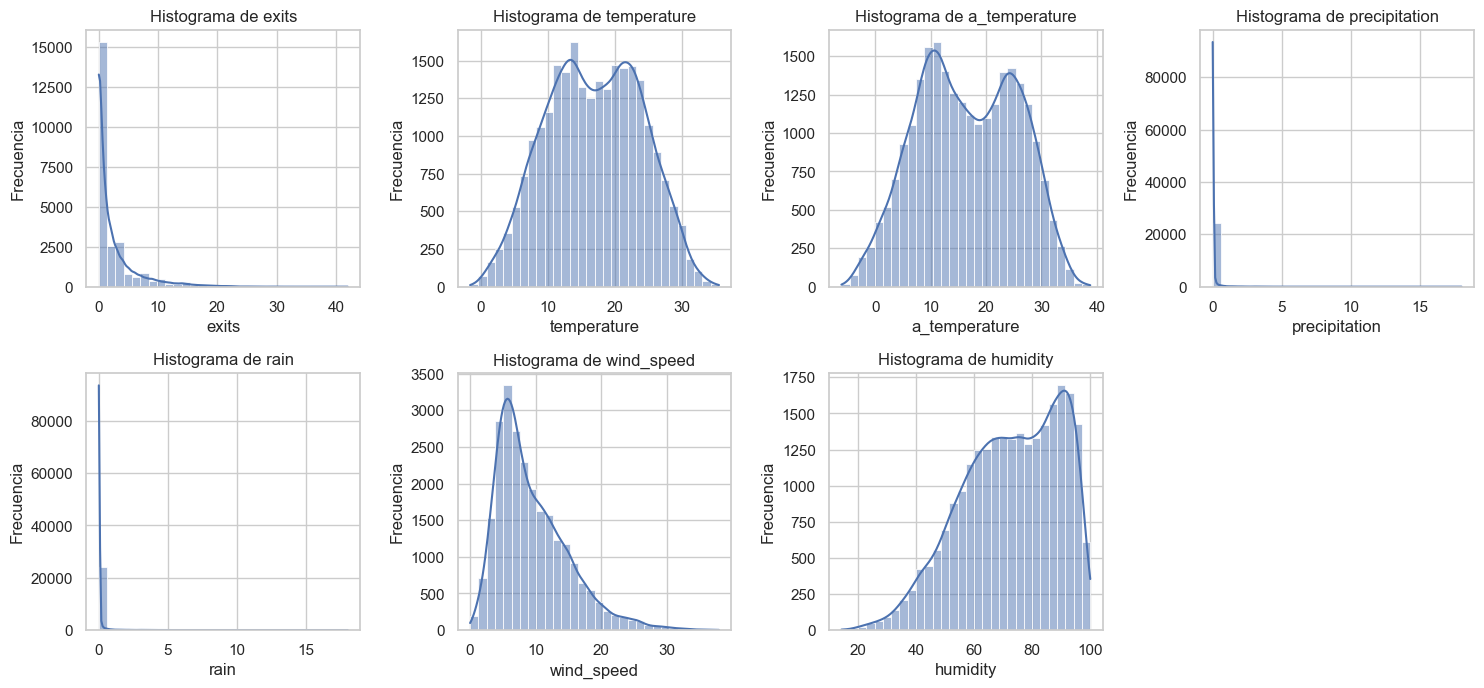

In [138]:
# Lista de variables numéricas
numeric_vars = ["exits", "temperature", "a_temperature", "precipitation", "rain", "wind_speed", "humidity"]

# Visualización de histogramas para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show();

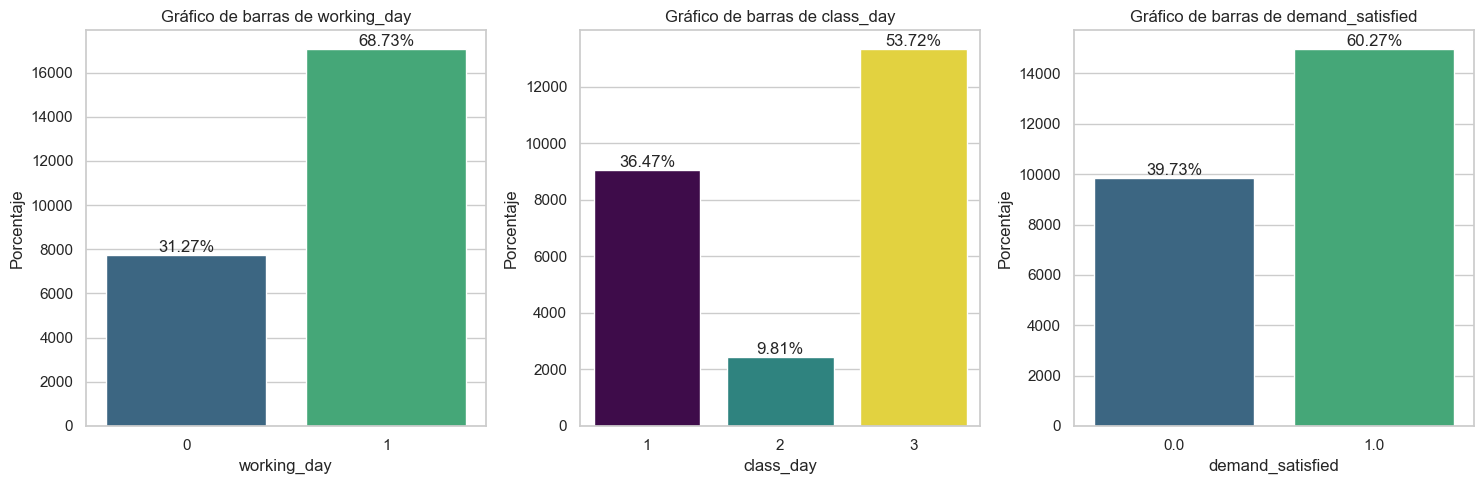

In [139]:
# Defining the list of categorical variables
categorical_vars = ['working_day', 'class_day', 'demand_satisfied']

# Plotting bar charts for categorical variables with percentages
plt.figure(figsize=(15, 5))

for i, var in enumerate(categorical_vars):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=var, data=data, hue=var, legend=False, palette='viridis')
    plt.title(f'Gráfico de barras de {var}')
    plt.xlabel(var)
    plt.ylabel('Porcentaje')

    # Calculate the percentages and display them on the bars
    total = len(data[var])  # Total number of records for normalization
    for p in plt.gca().patches:
        height = p.get_height()  # Get the height of each bar
        # Put the annotation on the bar
        plt.gca().text(p.get_x() + p.get_width() / 2, height + 2, '{:1.2f}%'.format((height / total) * 100),
                       ha="center", va='bottom')

plt.tight_layout()
plt.show();


### **Realción de la variable objetivo con el resto de variables**

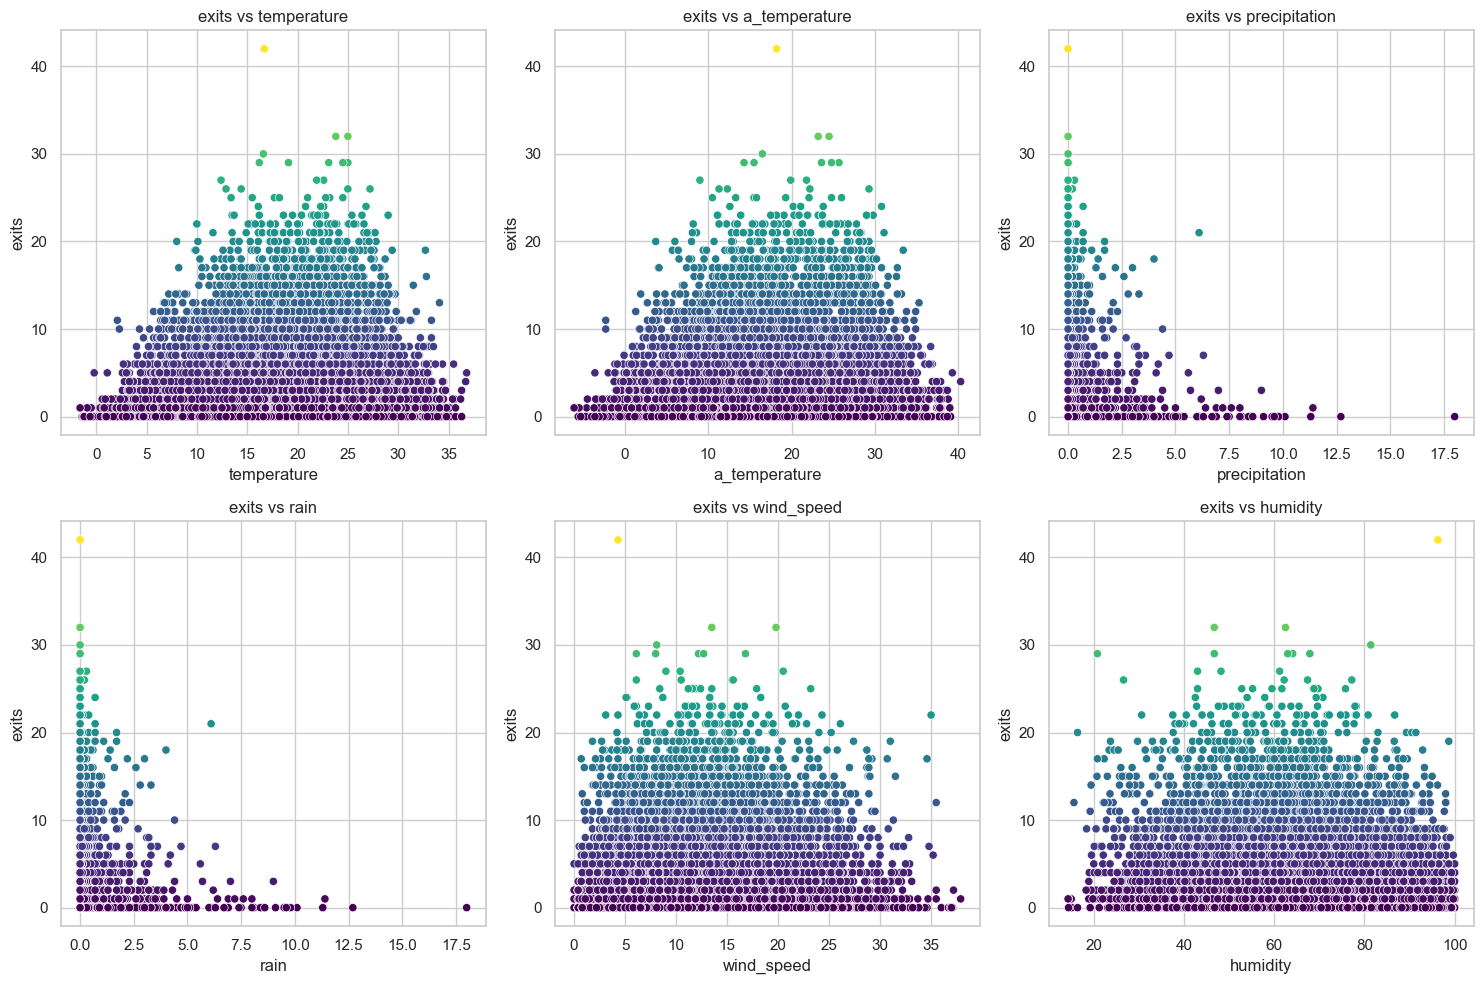

In [100]:
numeric_vars_without_exits = ["temperature", "a_temperature", "precipitation", "rain", "wind_speed", "humidity"]

# Gráficos de dispersión para variables numéricas
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_vars_without_exits, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=data, x=var, y="exits", hue='exits', legend=False, palette="viridis")
    plt.title(f'exits vs {var}')

plt.tight_layout()
plt.show();

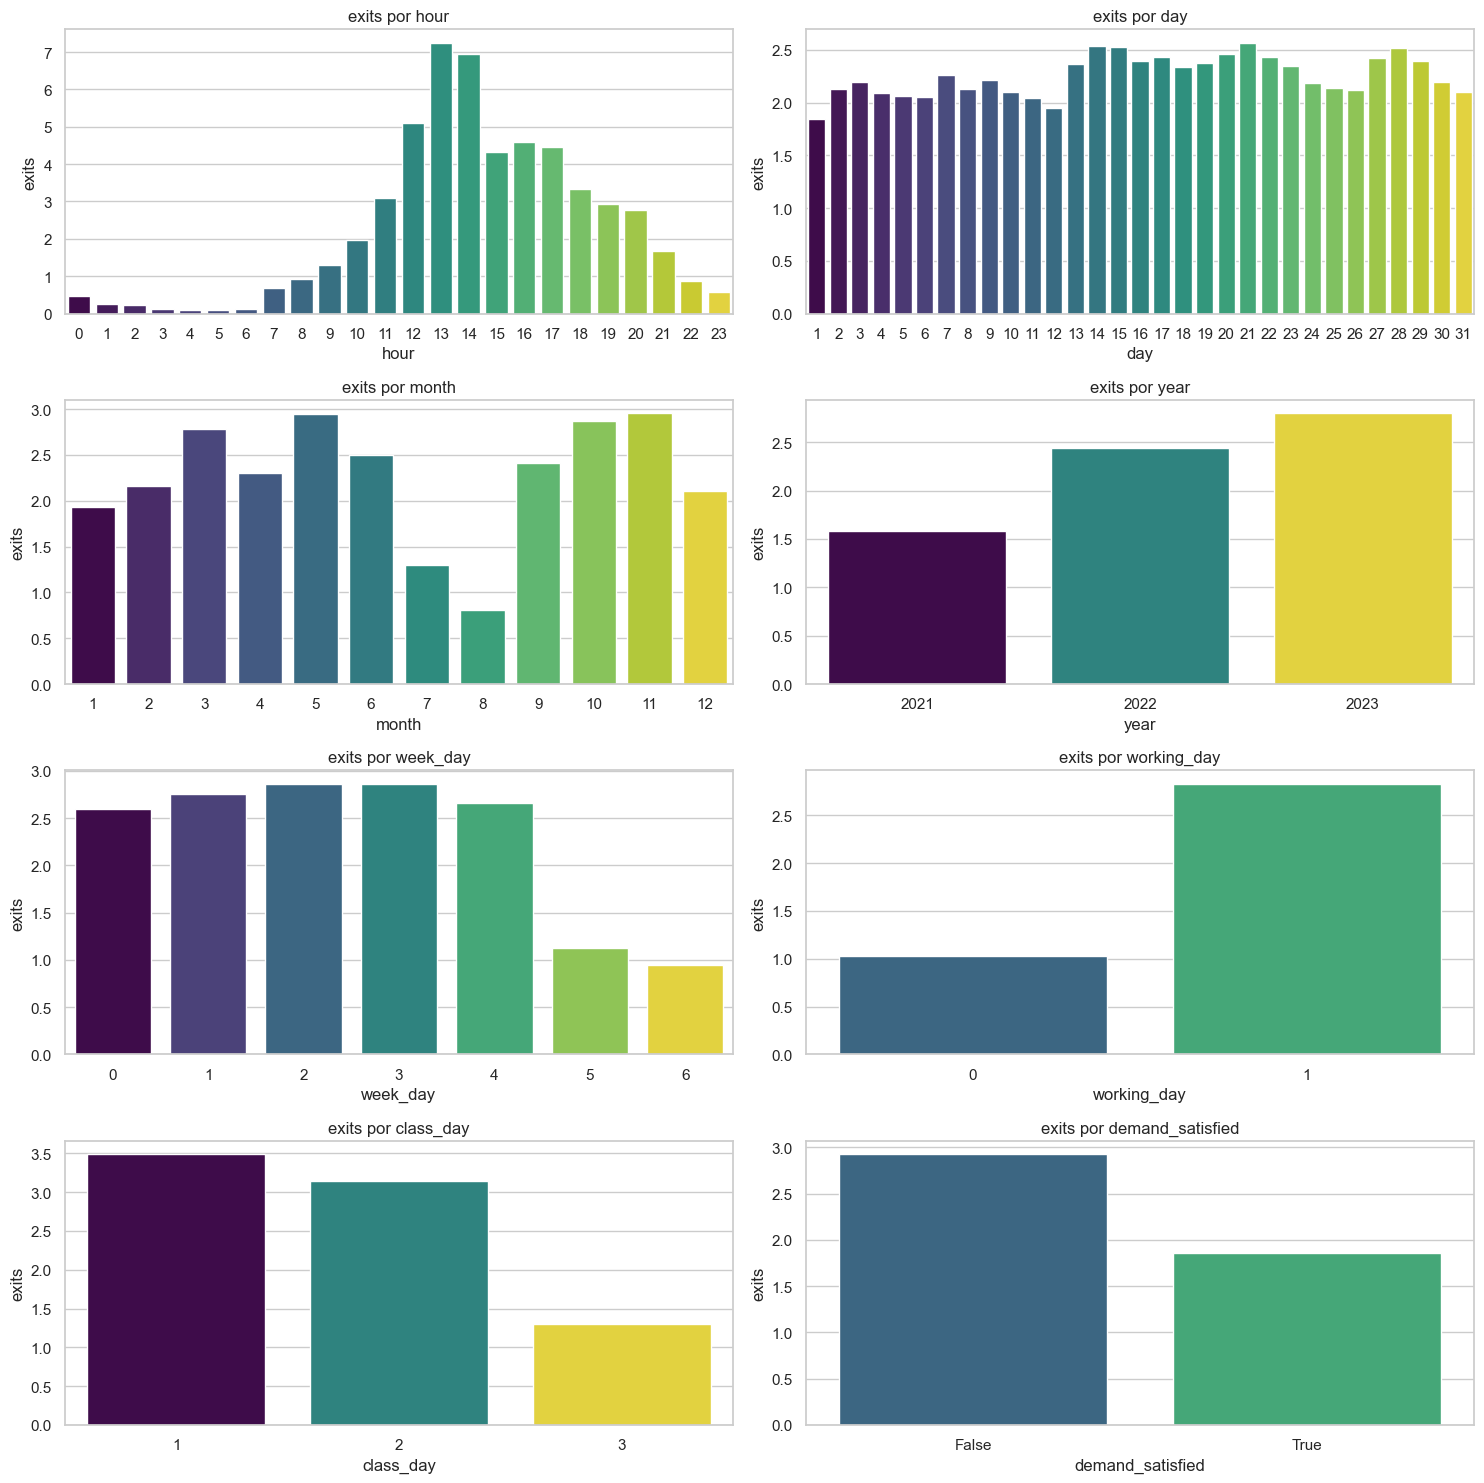

In [101]:
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day", "demand_satisfied"]

plt.figure(figsize=(15, 15))
for i, var in enumerate(categorical_vars_selected, 1):
    plt.subplot(4, 2, i)
    sns.barplot(data=data, x=var, y="exits", errorbar=None,  hue=var, legend=False, palette="viridis") 
    plt.title(f'exits por {var}')

plt.tight_layout()
plt.show();

(<Figure size 1000x800 with 1 Axes>, <Axes: >)

<Axes: >

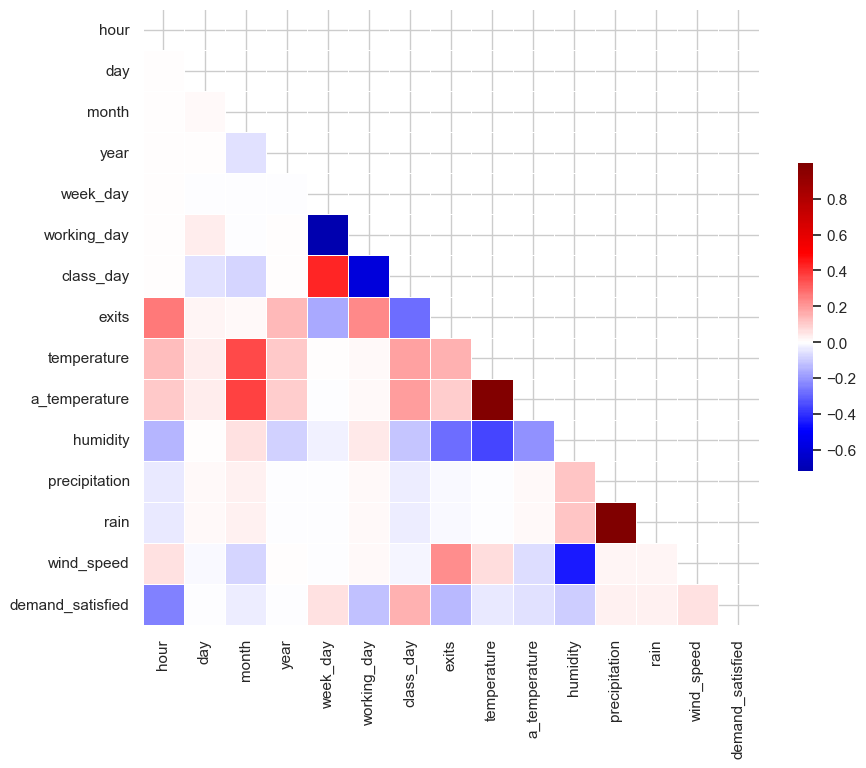

In [102]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

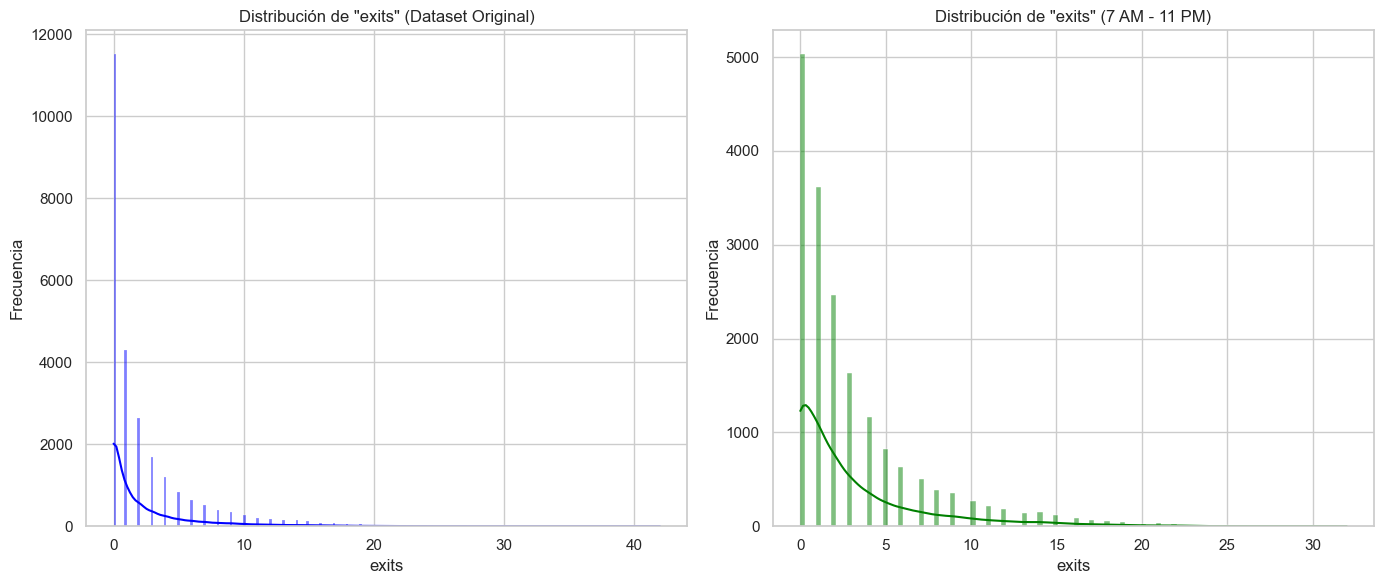

In [114]:
# Creating a copy of the dataset that only contains records between 7 AM and 11 PM (hours 7 to 23)
filtered_data = data[(data['hour'] >= 7) & (data['hour'] <= 23)]

# Plotting the distribution of 'exits' for the original and filtered datasets
plt.figure(figsize=(14, 6))

# Original dataset
plt.subplot(1, 2, 1)
sns.histplot(data['exits'], kde=True, color='blue')
plt.title('Distribución de "exits" (Dataset Original)')
plt.xlabel('exits')
plt.ylabel('Frecuencia')

# Filtered dataset
plt.subplot(1, 2, 2)
sns.histplot(filtered_data['exits'], kde=True, color='green')
plt.title('Distribución de "exits" (7 AM - 11 PM)')
plt.xlabel('exits')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show();

In [141]:
from sklearn.metrics import r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Preparar los datos para la regresión (seleccionar las variables independientes y la variable objetivo)
X = filtered_data.drop(['exits', 'demand_satisfied'], axis=1).select_dtypes(include=np.number)  # Solo variables numéricas
y = filtered_data['exits']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the Random Forest model
rf = RandomForestRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the model on the test set
y_pred = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)

# Print the best parameters and R2 score
print("Best parameters:", best_params)
print("R2 score:", r2)

/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/fernandoguiraonunez/Library/Python/3.11/lib/python/site-packages/sklearn/base.py

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
R2 score: 0.9360581812351724
